# Meal Cost & Nutritional Analysis — Starter Notebook

Base path is set to `/Projects/memory_care_meals`. If you place this folder elsewhere, update `base_path` below.

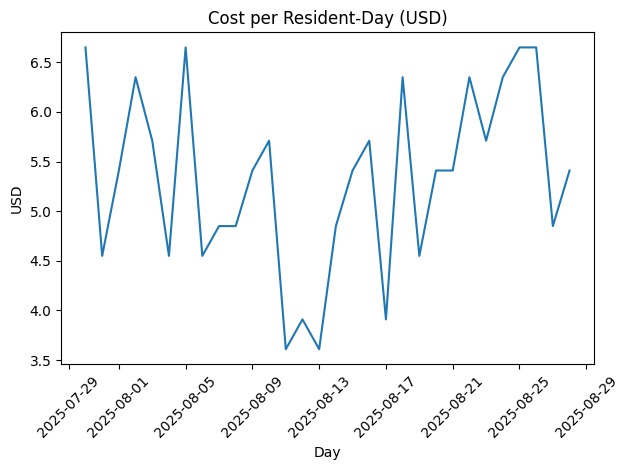

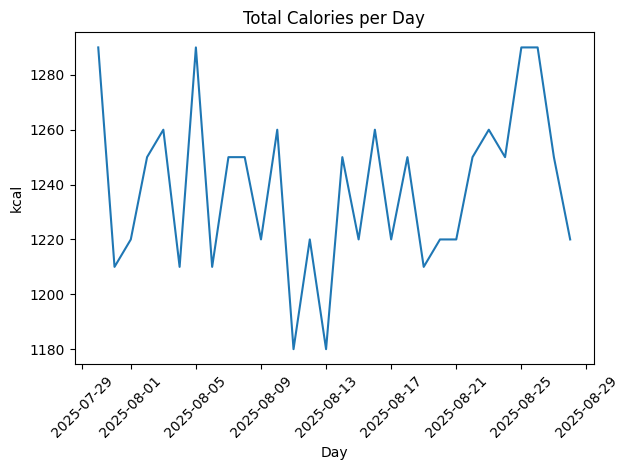

Saved daily_summary.csv and daily_checks.csv


In [3]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

base_path = "/Projects/memory_care_meals"

residents = pd.read_csv(f"{base_path}/residents.csv")
ingredients = pd.read_csv(f"{base_path}/ingredients.csv")
recipes = pd.read_csv(f"{base_path}/recipes.csv")
recipe_ingredients = pd.read_csv(f"{base_path}/recipe_ingredients.csv")
menu = pd.read_csv(f"{base_path}/menu_calendar.csv")
standards = pd.read_csv(f"{base_path}/nutrition_standards_daily.csv")

menu_detail = menu.merge(recipes, on="recipe_id", how="left")
menu_detail["date"] = pd.to_datetime(menu_detail["date"])

daily_nutrition = menu_detail.groupby(menu_detail["date"].dt.date)[["calories_kcal","protein_g","carbs_g","fat_g","sodium_mg","fiber_g"]].sum().reset_index()
daily_nutrition.rename(columns={"date":"day"}, inplace=True)

N = len(residents)
daily_cost = menu_detail.groupby(menu_detail["date"].dt.date)["estimated_cost_per_serving_usd"].sum().reset_index(name="cost_per_resident_day_usd")
daily_cost["cost_per_resident_day_usd"] = daily_cost["cost_per_resident_day_usd"].round(2)

summary = daily_nutrition.merge(daily_cost, left_on="day", right_on="date", how="left").drop(columns=["date"])

def within_range(val, metric):
    row = standards[standards["metric"]==metric].iloc[0]
    return (val >= row["min"]) and (val <= row["max"])

checks = pd.DataFrame({
    "day": summary["day"],
    "calories_ok": summary["calories_kcal"].apply(lambda x: within_range(x, "calories_kcal")),
    "protein_ok": summary["protein_g"].apply(lambda x: within_range(x, "protein_g")),
    "carbs_ok": summary["carbs_g"].apply(lambda x: within_range(x, "carbs_g")),
    "fat_ok": summary["fat_g"].apply(lambda x: within_range(x, "fat_g")),
    "sodium_ok": summary["sodium_mg"].apply(lambda x: within_range(x, "sodium_mg")),
    "fiber_ok": summary["fiber_g"].apply(lambda x: within_range(x, "fiber_g")),
})

summary_sorted = summary.sort_values("day")

plt.figure()
plt.plot(summary_sorted["day"], summary_sorted["cost_per_resident_day_usd"])
plt.title("Cost per Resident-Day (USD)")
plt.xlabel("Day"); plt.ylabel("USD"); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

plt.figure()
plt.plot(summary_sorted["day"], summary_sorted["calories_kcal"])
plt.title("Total Calories per Day")
plt.xlabel("Day"); plt.ylabel("kcal"); plt.xticks(rotation=45); plt.tight_layout(); plt.show()

pd.DataFrame(summary).to_csv(f"{base_path}/daily_summary.csv", index=False)
pd.DataFrame(checks).to_csv(f"{base_path}/daily_checks.csv", index=False)
print("Saved daily_summary.csv and daily_checks.csv")
